# Amazon Fine Food Reviews Analysis



The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


#### In this assignment I perform the following steps,

1.  Data reading
2.  Exploratory Data Analysis
3.  Text Preprocessing on Review text data and Summary data
4.  Time based sorting of data and sample the data from the dataset

Next I do all the 4 featurizations - BoW, TFIDF, AvgW2V, TFIDF-W2V. On all these featurizations below steps are performed:-

5. Applying K-means clustering on featurizations
6. Finding best K value by elbow method
7. Retrain the K-means model on optimal k
8. Finding number of words in each cluster
9. Printing top 20 words from each cluster
10. Word Clouds for each cluster

# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


In [3]:

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [4]:
# Loading the data
# using SQLite Table to read data.
con = sqlite3.connect('I:\Python\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(5)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is necessary to remove duplicates in order to get unbiased results for the analysis of the data. Hence in order to reduce redundancy it's better to eliminate the rows that have same parameters.

The method used to perform deduplication is that, we first sort the data according to ProductId and then just keep the first similar product review and delete the others. This method ensures that there is only one representative for each product.

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data = filtered_data.sort_values('ProductId', axis = 0, ascending = True, inplace = False, kind = 'quicksort', na_position = 'last')

#Dropping duplicates. It says that find duplicates with {'UserId', 'ProfileName', 'Time', 'Text'} values same. Then it is a duplicate
# By using drop_duplicate function we just keep the first product Id of the duplicates and remove the remaining.
final_data = sorted_data.drop_duplicates(subset = {'UserId', 'ProfileName', 'Time', 'Text'}, keep = 'first', inplace = False)

# Now it prints total reviews after removing duplicates.
print('Total number of reviews in the dataframe after removing duplicated:', final_data.shape)


Total number of reviews in the dataframe after removing duplicated: (364173, 10)


In [6]:
# HelpfulnessNumerator should always be less than HelpfulnessDenominator. 
# So check if any reviews have HelpfulnessNumerator greater than HelpfulnessDenominator and remove them

final_data = final_data[final_data.HelpfulnessNumerator <= final_data.HelpfulnessDenominator]
final_data.shape

(364171, 10)

In [7]:
#Checking to see how much % of data still remains
(final_data['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25852107399194

In [8]:
# Lets see how many total reviews left
print(final_data.shape)

#How many positive and negative reviews are present in the dataset?
final_data['Score'].value_counts()


(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#### Observation:-

From the above output we can see that there are many positive reviews and fewer negative reviews.


#  [3] Text Preprocessing

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis.

1. By removing stop-words, BoW vector will be small and more meaningful
2. Lemmatization is a process of breaking a sentence into words. It is language and context dependent

Hence in the Preprocessing phase we do the following in the order below:-

1. Remove all URL's
2. Remove all tags from the strings
3. Expanding English language contractions like, you've -> you have
4. Remove any punctuations or limited set of special characters like , or . or # etc.
5. Check if the word is made up of english letters and is not alpha-numeric
6. Remove words with numbers
7. Remove spacial characters
8. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
9. Convert the words to lowercase
10. Remove Stopwords
11. Finally Stemming the words which are related, to their stem form/root/base form (Snowball stemmer is used as it is obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews

## [3.1].  Preprocessing Review Text


In [9]:
# printing some random reviews
sent_5 = final_data['Text'].values[5]
print(sent_5)
print("="*50)

sent_60000 = final_data['Text'].values[60000]
print(sent_60000)
print("="*50)

sent_15500 = final_data['Text'].values[15500]
print(sent_15500)
print("="*50)

sent_4900 = final_data['Text'].values[4900]
print(sent_4900)
print("="*50)

A charming, rhyming book that describes the circumstances under which you eat (or don't) chicken soup with rice, month-by-month. This sounds like the kind of thing kids would make up while they're out of recess and sing over and over until they drive the teachers crazy. It's cute and catchy and sounds really childlike but is skillfully written.
<a href="http://www.amazon.com/gp/product/B000F4D5WG">Edward & Sons Organic Croutons, Italian Herbs, 5.25-Ounce Packs (Pack of 6)</a><br /><br />Knowing that I have to watch my calories I have been eating nothing but low cal foods for quite a while.  Part of my diet consists of big salads and low fat Progresso soups. I wanted something extra that I could add to a salad  and/or a soup.  I decided to try these.  They are extremely salty and aside from that have no other taste.  I would not re order these again.  I do admit that I do not care for salty foods but if salt is used the taste of it should not be so overwhelming. Some foods are understan

In [10]:
# Remove urls from text ----  https://stackoverflow.com/a/40823105/4084039
import re
sent_5 = re.sub(r"http\S+", "", sent_5)
sent_60000 = re.sub(r"http\S+", "", sent_60000)
sent_15500 = re.sub(r"http\S+", "", sent_15500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_60000)

<a href=" & Sons Organic Croutons, Italian Herbs, 5.25-Ounce Packs (Pack of 6)</a><br /><br />Knowing that I have to watch my calories I have been eating nothing but low cal foods for quite a while.  Part of my diet consists of big salads and low fat Progresso soups. I wanted something extra that I could add to a salad  and/or a soup.  I decided to try these.  They are extremely salty and aside from that have no other taste.  I would not re order these again.  I do admit that I do not care for salty foods but if salt is used the taste of it should not be so overwhelming. Some foods are understandably noted for being salty, anchovies, pretzels etc. I do eat pretzels and like them as long as I don't feel as if I put several tablespoons of salt in my mouth. I do not taste any of the herbs that I expected in a product which claims to have as one of it's ingredients Italian herbs.


In [11]:
# Removes all tags from a string --- https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element

from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_5, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_15500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

A charming, rhyming book that describes the circumstances under which you eat (or don't) chicken soup with rice, month-by-month. This sounds like the kind of thing kids would make up while they're out of recess and sing over and over until they drive the teachers crazy. It's cute and catchy and sounds really childlike but is skillfully written.
I use this exclusively in all my cooking...I don't understand why the price went up so drastically...I have many of the ladies I work with that are hooked on this product and they want me to get them more
Can't do sugar.  Have tried scores of SF Syrups.  NONE of them can touch the excellence of this product.Thick, delicious.  Perfect.  3 ingredients: Water, Maltitol, Natural Maple Flavor.  PERIOD.  No chemicals.  No garbage.Have numerous friends & family members hooked on this stuff.  My husband & son, who do NOT like "sugar free" prefer this over major label regular syrup.I use this as my SWEETENER in baking: cheesecakes, white brownies, muffin

In [12]:
# Expanding English language contractions  like, you've -> you have,  aren't -> are not
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
sent_5 = decontracted(sent_5)
print(sent_5)
print("="*50)

A charming, rhyming book that describes the circumstances under which you eat (or do not) chicken soup with rice, month-by-month. This sounds like the kind of thing kids would make up while they are out of recess and sing over and over until they drive the teachers crazy. It is cute and catchy and sounds really childlike but is skillfully written.


In [14]:
# Removes punctuations from strings ---  https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string-in-python
sent_5 = re.sub(r"http\S+", "", sent_5)
sent_60000 = re.sub(r'[^\w\s]','', sent_60000)
sent_15500 = re.sub(r'[^\w\s]','', sent_15500)
sent_4900 = re.sub(r'[^\w\s]','', sent_4900)

print(sent_60000)

a href  Sons Organic Croutons Italian Herbs 525Ounce Packs Pack of 6abr br Knowing that I have to watch my calories I have been eating nothing but low cal foods for quite a while  Part of my diet consists of big salads and low fat Progresso soups I wanted something extra that I could add to a salad  andor a soup  I decided to try these  They are extremely salty and aside from that have no other taste  I would not re order these again  I do admit that I do not care for salty foods but if salt is used the taste of it should not be so overwhelming Some foods are understandably noted for being salty anchovies pretzels etc I do eat pretzels and like them as long as I dont feel as if I put several tablespoons of salt in my mouth I do not taste any of the herbs that I expected in a product which claims to have as one of its ingredients Italian herbs


In [15]:
#remove words with numbers --- https://stackoverflow.com/a/18082370/4084039
sent_60000 = re.sub("\S*\d\S*", "", sent_60000).strip()
print(sent_60000)

a href  Sons Organic Croutons Italian Herbs  Packs Pack of  br Knowing that I have to watch my calories I have been eating nothing but low cal foods for quite a while  Part of my diet consists of big salads and low fat Progresso soups I wanted something extra that I could add to a salad  andor a soup  I decided to try these  They are extremely salty and aside from that have no other taste  I would not re order these again  I do admit that I do not care for salty foods but if salt is used the taste of it should not be so overwhelming Some foods are understandably noted for being salty anchovies pretzels etc I do eat pretzels and like them as long as I dont feel as if I put several tablespoons of salt in my mouth I do not taste any of the herbs that I expected in a product which claims to have as one of its ingredients Italian herbs


In [16]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_4900 = re.sub('[^A-Za-z0-9]+', ' ', sent_4900)
print(sent_4900)

Cant do sugar Have tried scores of SF Syrups NONE of them can touch the excellence of this productbr br Thick delicious Perfect 3 ingredients Water Maltitol Natural Maple Flavor PERIOD No chemicals No garbagebr br Have numerous friends family members hooked on this stuff My husband son who do NOT like sugar free prefer this over major label regular syrupbr br I use this as my SWEETENER in baking cheesecakes white brownies muffins pumpkin pies etc Unbelievably deliciousbr br Can you tell I like it 


In [17]:
# Converting words into lowercase
sent_4900 = sent_4900.lower()
print(sent_4900)

cant do sugar have tried scores of sf syrups none of them can touch the excellence of this productbr br thick delicious perfect 3 ingredients water maltitol natural maple flavor period no chemicals no garbagebr br have numerous friends family members hooked on this stuff my husband son who do not like sugar free prefer this over major label regular syrupbr br i use this as my sweetener in baking cheesecakes white brownies muffins pumpkin pies etc unbelievably deliciousbr br can you tell i like it 


In [18]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [19]:
# Combining all the above stundents 
from tqdm import tqdm
final_strings = []
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
# tqdm is for printing the status bar
for sentence in tqdm(final_data['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)  # To remove urls from text
    sentence = BeautifulSoup(sentence, 'lxml').get_text() # To remove all tags from an element
    sentence = decontracted(sentence) # Expanding English language contractions  like, you've -> you have,  aren't -> are not
    sentence = re.sub(r'[^\w\s]','', sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip() # removes words with numbers
    sentence = re.sub('[^A-Za-z]+', ' ', sentence) # removes special characters
    sentence = sentence.lower()  # Converting words into lowercase
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    final_strings.append(sentence.strip())

100%|██████████| 364171/364171 [03:30<00:00, 1729.77it/s]


In [20]:
final_strings[55000]

'great product anyone would love even not gluten free great servicefast'

In [21]:
# store final_data table into an SQlLite table for future.
conn = sqlite3.connect('final_data.sqlite')
c=conn.cursor()
conn.text_factory = str
final_data.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)


In [22]:
final_data['CleanedText'] = final_strings
final_data.shape
final_data.head(3)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...


In [23]:
print(final_data['Score'].value_counts())

1    307061
0     57110
Name: Score, dtype: int64


## [3.2] Preprocessing Reviews Summary

In [24]:
# printing some random reviews
sent_6 = final_data['Text'].values[6]
print(sent_6)
print("="*50)

sent_5000 = final_data['Text'].values[5000]
print(sent_5000)
print("="*50)

sent_50000 = final_data['Text'].values[50000]
print(sent_50000)
print("="*50)

sent_355000 = final_data['Text'].values[355000]
print(sent_355000)
print("="*50)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
late delivered, I paid extra charge for faster delivery but is not delivered on the time i've expected it.
We use marinade on a weekly basis, and this is another flavor from Lawry's that is really good.  Not too spicy or overwhelming, making it a good marinade for everyone (even picky kids who don't like spicy tastes).
Great taste and amazing crunch. If you have never experienced the large/deluxe/fancy peanuts and have only had 

In [25]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_6, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_5000, 'lxml')
text= soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_50000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_355000, 'lxml')
text = soup.get_text()
print(text)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.First, this book taught him the months of the year.Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
late delivered, I paid extra charge for faster delivery but is not delivered on the time i've expected it.
We use marinade on a weekly basis, and this is another flavor from Lawry's that is really good.  Not too spicy or overwhelming, making it a good marinade for everyone (even picky kids who don't like spicy tastes).
Great taste and amazing crunch. If you have never experienced the large/deluxe/fancy peanuts and have only had Planters or regular "salted in the s

In [26]:
# Expanding English language contractions  like, you've -> you have,  aren't -> are not
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [27]:
sent_5000 = decontracted(sent_5000)
print(sent_5000)
print("="*50)

late delivered, I paid extra charge for faster delivery but is not delivered on the time i have expected it.


In [28]:
#remove words with numbers ---- https://stackoverflow.com/a/18082370/4084039
sent_6 = re.sub("\S*\d\S*", "", sent_6).strip()
print(sent_6)

I set aside at least an hour each day to read to my son  y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to  y/o old to  /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [29]:
#remove spacial character ----- https://stackoverflow.com/a/5843547/4084039
sent_355000 = re.sub('[^A-Za-z0-9]+', ' ', sent_355000)
print(sent_355000)

Great taste and amazing crunch If you have never experienced the large deluxe fancy peanuts and have only had Planters or regular salted in the shell you are in for a wonderful experience The intense taste and solid crunch will keep your hand in the can til they are gone 


In [30]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [31]:
# Performing all the preprocessing steps on Summary data.
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"
from tqdm import tqdm
summary_data = []
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
# tqdm is for printing the status bar
for sentence in tqdm(final_data['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)  # To remove urls from text
    sentence = BeautifulSoup(sentence, 'lxml').get_text() # To remove all tags from an element
    sentence = decontracted(sentence) # Expanding English language contractions  like, you've -> you have,  aren't -> are not
    sentence = re.sub(r'[^\w\s]','', sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip() # removes words with numbers
    sentence = re.sub('[^A-Za-z]+', ' ', sentence) # removes special characters
    sentence = sentence.lower()  # Converting words into lowercase
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    summary_data.append(sentence.strip())

100%|██████████| 364171/364171 [01:56<00:00, 3126.38it/s]


In [32]:
summary_data[56000]

'awesome yummy'

In [33]:
# store final_data table into an SQlLite table for future.
conn = sqlite3.connect('final_data.sqlite')
c=conn.cursor()
conn.text_factory = str
final_data.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)


In [34]:
final_data['CleanedSummary'] = summary_data 
final_data.shape
final_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...,love book miss hard cover version
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...,chicken soup rice months


In [35]:
print(final_data['Score'].value_counts())

1    307061
0     57110
Name: Score, dtype: int64


## 4. Sample the data from the Dataset

### [4.1] Time Based Sorting


In [36]:
# sorting data using time
final_data['Time'] = pd.to_datetime(final_data['Time'])
final_data = final_data.sort_values(by = 'Time', ascending = True)


In [37]:
# display top 5 rows
final_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1970-01-01 00:00:00.939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1970-01-01 00:00:00.940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...,whole series great way spend time child
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1970-01-01 00:00:00.944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuice well written movie everything exce...,entertainingl funny
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1970-01-01 00:00:00.944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captured film starring mic...,modern day fairy tale
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,1970-01-01 00:00:00.946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuice excellent funny movie keaton hilar...,fantastic


### 4.2 Sample the data from the Dataset

In [38]:
# taking top 40000 data points as my laptop is computationally low 
total_score = final_data.iloc[:40000,:]
print(total_score.shape)
print(total_score['Score'].value_counts())

(40000, 12)
1    35595
0     4405
Name: Score, dtype: int64


# K-means Clustering 

1. In case of classification, Yi's belongs to set of values, in case of regression Yi's belongs to real values.
2. In case of clustering only Xi's are given, no Yi's. The task in this case is to group/cluster similar data points. Points in a cluster are close together and points in different clusters are far away from eachother.
3. In case of clustering there is a doubt that how to measure how well the algorithm performed. In case of classification/regression where we have Yi's and we have performance metrics to measure the algorithm performance. But in case of clustering there are no Yi's.
4. There are 3 most used and important techniques of clustering.
   1. K-means
   2. Hierarchical clustering
   3. DBSCAN algorithm
5. Clustering is called as UnSupervised learning, because there are no Yi's to supervise learning. Both classification and regression are called supervised learning, beacause we have Yi's in this case.
6. There is another case called semi-supervised learning where it has 2 subsets of data, on one subset of data we have Yi's to supervise the learning while the other subset of data where we don't have Yi's. It is between unsupervised and supervised learning.

##### Metrics for clustering:-

1. It the performance measure of how good the clustering is. None of the metrics which we used for classification and regression doesn't work in case of clustering as it doesn't have Yi's.
2. Inter-cluster = across or between clusters,  intra-cluster = within a cluster,  where intra cluster distance should be small and inter-cluster distance should be large is the basis to measure clustering.
3. There is a metric called Dunn-index (D) to measure clustering where, we should get low intra-cluster distance and high inter-cluster distance.

### K-means:-
1. It is one of the popular and simple clustering algorithm. 'K' in K-means is the number of clusters. If we want to do K-means clustering, we have to do the K value which is the hyper parameter in clustering, which we can find through ideas like Cross validation.
2. So in case of K-means clustering, it groups the clusters into 'K' clusters based on the K value. For each cluster there is a centroid point Ci. Eack cluster of points is called a set and no point belongs to 2 sets.
3. When we have k-clusters, we get k-centroids and k-sets of points.
4. Centroid in any cluster is mean(sum of all the points). K-means clustering is a centroid based clustering scheme as we define each cluster using its centriod, where points are assigned to a cluster based on the nearest centroid/proximity idea.
5. So if get K-centroids we can get k-sets by using nearest centroid method for every point. To find k-centroids, there is a algorithm called lloyd's algorithm.

The conditions/constraints in K-means clustering is, each point belongs to atleast one cluster and between 2 clusters there are no common points.

So in k-means algorithm, the intra cluster distance between the points from the centroid should be minimized or square distance of points from centroid in a cluster should be minimized.

The k-means problem is a np-hard problem to solve which have high time complexity. So in this case we can solve the problem approximately. One such approximation algorithm is lloyd's algorithm.

##### Lloyd's algorithm:-

Through this algorithm we can find k-centroids for k-means. This is the approximation algorithm for k-means.

Steps:

1. Initialization:- randomly pick k-points from dataset D and call them k-centroids. This is random initialization. 
2. Assignment:- for each point in dataset D, select the nearest centroid from the set of randomly picked centroids which is near to point. Then add the point to a set which is corresponding to that centroid.
3. Recompute centroid stage:- It is also called as update stage. Here we recalculate/update the centroids.
4. Repeat step 2 and 3 until convergence, which means when centroids don't change much where the distance between the old and new centroid is very small, then we can stop the loop and get the final centroids. This is a iterative algorithm.

K-means has of problem of initialization sensitivity, it means, final clusters and centroids depend on how we pick random points in initialization stage. By changing the initial points while initialization, we can get completely different results at the end.
So there are 2 ways to deal with this problem.
1. we can repeat k-means multiple times with different initializations and we will pick the best clustering based on smaller intra-cluster  and larger inter-cluster distances. This process requires more computational effort.
2. K-means++ :- It replaces random initialization with a smart initialization scheme. Otherthan this,  remaining algorithm is same as k-means.

### K-means++ process:

Initialization in k-means++ :- 
1. pick the first centroid randomly from dataset.
2. For all the remaining points in dataset, create a distribution, which is, for each point we calculate the square of the distance  from the point to the nearest centroid.
3. after getting all the distances, we pick a point from the points (remaining in dataset except initial centroid/point) with a probability proportional to distance di, where the point with large distance/far away from centroid has high chances to become the nest centroid. So this is called probabilistic approach of picking points as we are picking the new centroids  that are as far as possible from other centroids that are already pickedup. 
4. In k-means instead of doing above process probabilistic way, we can't just pick a point deterministically which has highest value of dustance, beacuse k-means++ gets effected by outliers and by picking through deterministic way only outliers will become the centroids. So by picking the point in the probabilistic way, the impact of outliers can be reduced.

K-means also have few limitations. It is not a perfect scheme and is a good approximation. It is not easy to evaluate clustering as there are no Yi's and we have to depend only on intra and inter cluster distances.

### K-medoids:-
1. If the each centroid is a datapoint in a dataset then the K-means is called K-medoids because here we don't have mean points as the centroids and we have actual data points as centroids. K-medoids is a popular algorithm when we want to interpret/read the centroids.
2. One of the popular algorithm for K-medoids is Partitioning around medoids (PAM). Its similar to k-means with some differences.
###### PAM :-
1. Initialization:- same as k-means++
2. Assignment:- same as k-means++. we use proximity and closest medoid to the point. 
3. Update/recompute centroids:- This stage differs from k-means++. Here we don't use mean approach as in k-means++. In case of PAM, we swap each medoid with non-medoid point. Then check if the loss decreases, keep the swap else undo swap.
4. If the swap is successfull ( when loss value is less) then we re-assign the points to appropriate clusters.
5. The advantage of K-medoids is interpretability and we can use kernalization.

##### Determining right K:-
1. In k-means K is the hyperparameter. we can determine it through domain knowledge. In case of amazon food reviews, as we know there are 2 typesof reviews (+ve and -ve) we can take k=2.
2. If we want to find right K then we use elbow method or knee method. In this method, we plot loss function of k-means on y-axis and different number of K-values on x-axis. The k-value which results in lowest value of loss function then that is taken as best K value.

The time complexity of k-means is O(nkdi) where n = number of points, k = number of clusters, d = dimensionality of data , 
i = number of iterations . typically k is small k<=10 and i<=300. This can be approximated to O(nd) where n is large.

The space complexity is O(nd+kd) , k<<n, k - centroids, n - datapoints. This also can be approximated as O(nd) which is a linear.

K-means is fast for real world applications.


# [5] Featurizations

In [39]:
X = total_score['CleanedText']
#reviews_data = total_score['Text']

## [5.1] BAG OF WORDS

In [40]:
# BoW
# Creating a variable count_vect of CountVectorizer type and inititalizing it.

count_vect = CountVectorizer() #in scikit-learn

bow_data = count_vect.fit_transform(X)

print("the type of count vectorizer ", type(bow_data))
print(bow_data.get_shape())
print("the number of unique words are ", bow_data.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
(40000, 62436)
the number of unique words are  62436


## 6. K-Means Clustering

### 6.1 Applying K-means clustering on BoW

### 6.2 Finding best K value by elbow method

In [41]:
# inertia = sum of intra-cluster distances across all cluster and it should be very low
from sklearn.cluster import KMeans

sum_of_intracluster_dist = []
K = [2,3,4,5,6,7,8,9,10]

for i in K:
    kmeans = KMeans(n_clusters = i, n_jobs = -1)
    kmeans.fit(bow_data)
    sum_of_intracluster_dist.append(kmeans.inertia_)
    

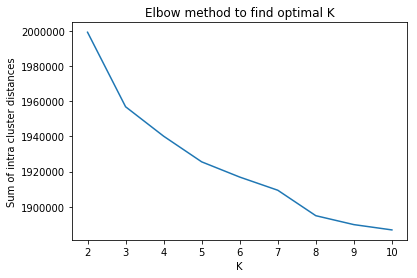

In [42]:
# Plotting between K and sum_of_intracluster_distances which is inertia
plt.plot(K, sum_of_intracluster_dist)
plt.xlabel('K')
plt.ylabel('Sum of intra cluster distances')
plt.title('Elbow method to find optimal K')
plt.show()

#### Observation:-
From the above plot with elbow method, I can take optimal K = 3 , as the graph after 3 decreases gradually

###  6.3 Retrain the model on optimal k 

In [43]:
optimal_k = KMeans(n_clusters = 3, n_jobs = -1)
km = optimal_k.fit(bow_data)

In [44]:
#words = [] , .decode('utf-8')
words = []
for i in X:
    sent = []
    for word in i.split():
        sent.append(word)
    words.append(sent)

In [45]:
km.labels_.shape[0]

40000

### 6.4 Finding number of words in each cluster

In [48]:
words_data = words
C1 = []
C2 = []
C3 = []

for i in range(km.labels_.shape[0]):
    if km.labels_[i] == 0:
        C1.append(words_data[i])
    elif km.labels_[i] == 1:
        C2.append(words_data[i])
    else:
        C3.append(words_data[i])
                
print("Number of words in Cluster 1 : ",len(C1))
print("Number of words in Cluster 2 : ",len(C2))
print("Number of words in Cluster 3 : ",len(C3))


Number of words in Cluster 1 :  1017
Number of words in Cluster 2 :  6103
Number of words in Cluster 3 :  32880


### 6.5 Printing top 20 words from each cluster

In [52]:
# Reference - https://stackoverflow.com/questions/27889873/clustering-text-documents-using-scikit-learn-kmeans-in-python?rq=1
# https://pythonprogramminglanguage.com/kmeans-text-clustering/

def show_important_words(vectorizer, km): # To print top 10 words
    k=3
    print("Top terms per cluster:")
    words_order = km.cluster_centers_.argsort()[:, ::-1]
    features = count_vect.get_feature_names()
    for i in range(k):
        print("\nCluster %d: \n" % i)  
        for index in words_order[i, :20]:
            print('%s' % features[index])
show_important_words(count_vect, km)


Top terms per cluster:

Cluster 0: 

tea
not
teas
green
like
flavor
taste
good
organic
one
black
cup
also
drink
love
bags
no
great
would
use

Cluster 1: 

not
like
one
good
would
taste
flavor
product
get
no
great
really
food
much
also
even
coffee
eat
little
use

Cluster 2: 

not
great
good
like
product
taste
love
one
flavor
tea
best
coffee
would
no
get
find
amazon
use
really
also


### 6.6 Word Cloud for each cluster

#### Word cloud for cluster 1

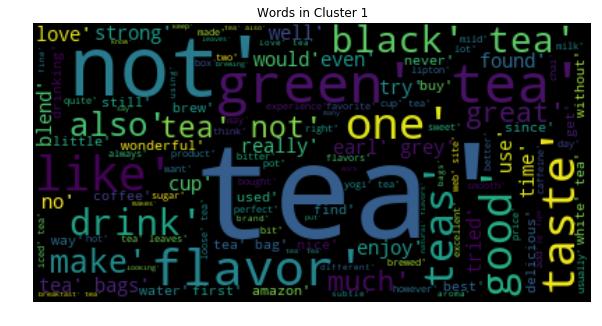

In [53]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 
stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(C1)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(C1))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 1")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


#### Observation:-

This word cloud majorly has words related to tea, how it tastes. It represents different types of tea and their tastes.

#### Word cloud for cluster 2

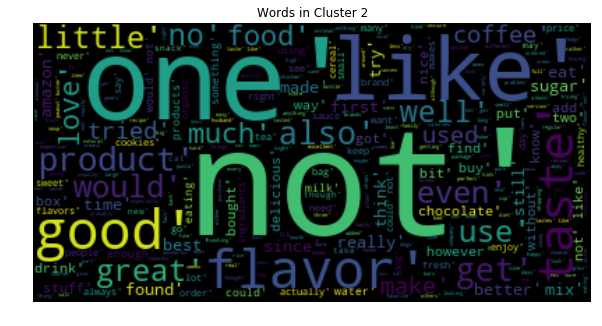

In [54]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 
stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(C2)), stopwords=stopwords_t)
wordcloud.generate(str(C2))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 2")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


#### Observation:-

This word cloud represents words related to coffee, food and their taste, quantity. 

#### Word cloud for cluster 3

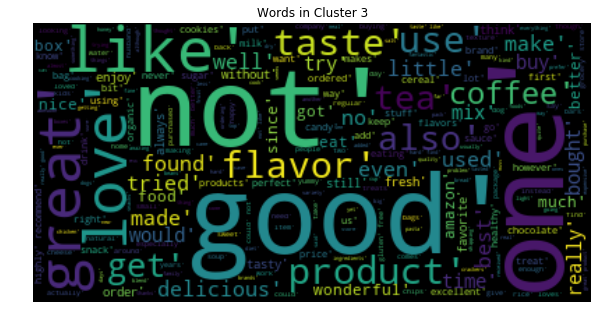

In [55]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 
stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(C3)), stopwords=stopwords_t)
wordcloud.generate(str(C3))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 3")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


#### Observation:-

This word cloud says about coffee and its taste. It represents that the product taste is not good.

## 7. TFIDF

### 7.1 Sample the dataset for TFIDF 

I am sampling 20000 data points from total data, as my laptop has less computational resources and TFIDF is taking many hours to compute than the other vectorizers. Please consider it. 

In [57]:
# taking top 20000 data points
total_score_new = final_data.iloc[:20000,:]
print(total_score_new.shape)
print(total_score_new['Score'].value_counts())

(20000, 12)
1    17826
0     2174
Name: Score, dtype: int64


### 7.2 TFIDF Vectorizer


In [58]:
X_new = total_score_new['CleanedText']
# reviews_data = total_score['Text']

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2)) 
tfidf_data = tf_idf_vect.fit_transform(X_new)

print("the type of TFIDF vectorizer ",type(tfidf_data))
print(tfidf_data.get_shape())
print("the number of unique words ", tfidf_data.get_shape()[1])
    

the type of TFIDF vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
(20000, 451610)
the number of unique words  451610


### 7.3 Applying K-means clustering on TFIDF

#### 7.4  Finding best K value by elbow method

In [59]:
# inertia = sum of intra-cluster distances across all cluster and it should be very low
from sklearn.cluster import KMeans

sum_of_intracluster_dist = []
K = [2,3,4,5,6,7,8,9,10]

for i in K:
    kmeans = KMeans(n_clusters = i, n_jobs = -1)
    kmeans.fit(tfidf_data)
    sum_of_intracluster_dist.append(kmeans.inertia_)
    

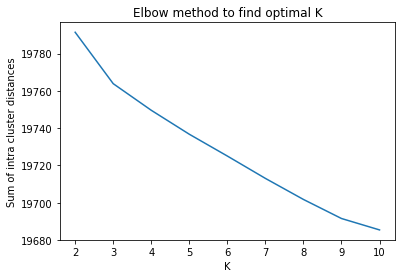

In [60]:
# Plotting between K and sum_of_intracluster_distances which is inertia
plt.plot(K, sum_of_intracluster_dist)
plt.xlabel('K')
plt.ylabel('Sum of intra cluster distances')
plt.title('Elbow method to find optimal K')
plt.show()

#### Observation:-

From the above plot with elbow method, I can take optimal K = 3 , as the graph after 3 decreases gradually


###  7.5 Retrain the model on optimal k and getting the reviews in each cluster

In [61]:
optimal_k = KMeans(n_clusters = 3, n_jobs = -1)
km = optimal_k.fit(tfidf_data)

In [62]:
km.labels_.shape[0]

20000

### 7.6 Finding number of words in each cluster

In [64]:
words_data = words
C1 = []
C2 = []
C3 = []

for i in range(km.labels_.shape[0]):
    if km.labels_[i] == 0:
        C1.append(words_data[i])
    elif km.labels_[i] == 1:
        C2.append(words_data[i])
    else:
        C3.append(words_data[i])
                
print("Number of words in Cluster 1 : ",len(C1))
print("Number of words in Cluster 2 : ",len(C2))
print("Number of words in Cluster 3 : ",len(C3))


Number of words in Cluster 1 :  1670
Number of words in Cluster 2 :  17071
Number of words in Cluster 3 :  1259


### 7.7 Printing top 20 words

In [67]:
def show_important_words(vectorizer, km): # To print top 10 words
    k=3
    print("Top terms per cluster:")
    words_order = km.cluster_centers_.argsort()[:, ::-1]
    features = tf_idf_vect.get_feature_names()
    for i in range(k):
        print("\nCluster %d: \n" % i)  
        for index in words_order[i, :20]:
            print('%s' % features[index])
show_important_words(tf_idf_vect, km)


Top terms per cluster:

Cluster 0: 

tea
green
teas
green tea
not
flavor
drink
like
good
black
great
taste
love
cup
one
bags
black tea
grey
best
organic

Cluster 1: 

not
great
good
like
product
taste
love
one
would
flavor
best
really
get
no
find
eat
food
chocolate
buy
little

Cluster 2: 

coffee
cup
pods
senseo
not
flavor
cup coffee
roast
like
good
great
strong
dark
one
espresso
taste
best
machine
pod
tried


### 7.8 Word cloud for cluster 1

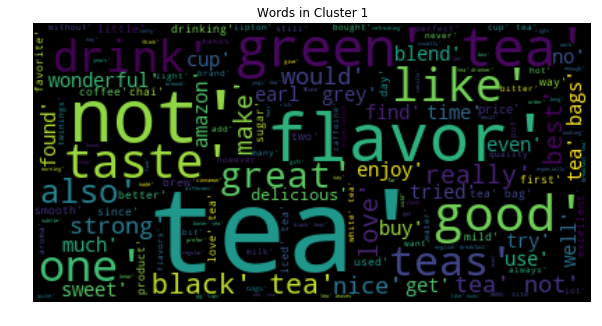

In [68]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 
stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(C1)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(C1))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 1")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


#### Observation:-

This Word cloud has information about different types of tea and their flavours. It also says how it tastes.

### 7.9 Word cloud for cluster 2

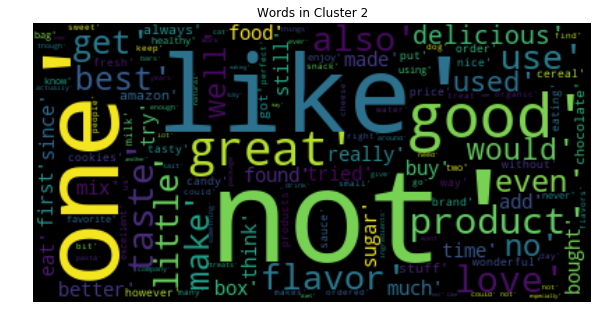

In [69]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 
stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(C2)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(C2))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 2")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


#### Observation:-

This word cloud has the information about some product and it says the product is not good . It also has some food information like it's flavor and taste.

### 7.10 Word cloud for cluster 3

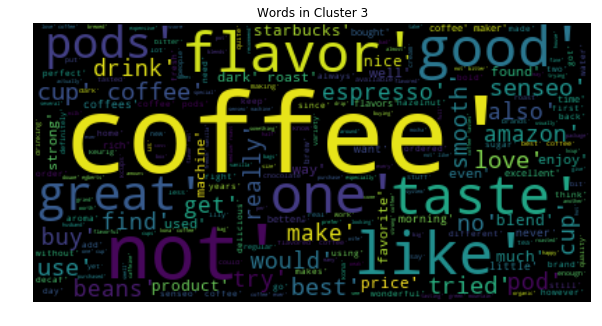

In [70]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 
stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(C3)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(C3))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 3")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


#### Observation:-

This word cloud represents the information of coffee, it's different varieties and their tastes. It says that the coffee taste good and great. It also information about the places where coffee can be found like starbucks, amazon.

## 8.  Word2Vec

In [43]:
# Splits sentences/reviews in X to words.
i=0
list_of_sent=[]
for sent in X:
    list_of_sent.append(sent.split())

In [44]:
# One sentence is converted into a list
print(X.values[0])
print("*****************************************************************")
print(list_of_sent[0])

witty little book makes son laugh loud recite car driving along always sing refrain learned whales india drooping roses love new words book introduces silliness classic book willing bet son still able recite memory college
*****************************************************************
['witty', 'little', 'book', 'makes', 'son', 'laugh', 'loud', 'recite', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'whales', 'india', 'drooping', 'roses', 'love', 'new', 'words', 'book', 'introduces', 'silliness', 'classic', 'book', 'willing', 'bet', 'son', 'still', 'able', 'recite', 'memory', 'college']


In [45]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(list_of_sent, min_count=5, size=50, workers=4)

#words = w2v_model[w2v_model.wv.vocab]
# we can get dictionary of all the words that we have
# we are storing Word2Vec model in w2v_model
words = list(w2v_model.wv.vocab)
print(len(words))

# prints 50 words
print("sample words ", words[0:50])

12752
sample words  ['witty', 'little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'learned', 'india', 'roses', 'love', 'new', 'words', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'somethingi', 'used', 'series', 'books', 'songs', 'student', 'teaching', 'turned', 'whole', 'school', 'purchasing', 'cd', 'children']


##  8.1 Avg-W2V

In [47]:
# average Word2Vec for Train data
# compute average word2vec for each review.
from tqdm import tqdm
#List to store all the avg w2vec's 
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # to count num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words:
            vec = w2v_model.wv[word] # vector of each word using w2v model
            sent_vec += vec # Adding the vectors
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words  # Taking average of vectors sum of the particular review
    sent_vectors_train.append(sent_vec)  # Storing the avg w2vec's for each review in the list
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

40000
50


## 8.2  Applying K-means clustering on AvgW2V

### 8.3 Finding best K value by elbow method

In [48]:
# inertia = sum of intra-cluster distances across all cluster and it should be very low
from sklearn.cluster import KMeans

sum_of_intracluster_dist = []
K = [2,3,4,5,6,7,8,9,10]

for i in K:
    kmeans = KMeans(n_clusters = i, n_jobs = -1)
    kmeans.fit(sent_vectors_train)
    sum_of_intracluster_dist.append(kmeans.inertia_)
    

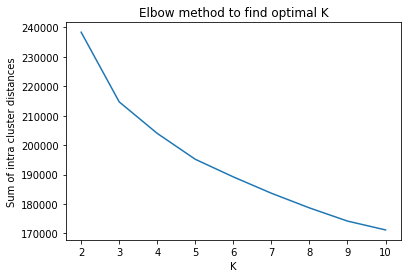

In [49]:
# Plotting between K and sum_of_intracluster_distances which is inertia
plt.plot(K, sum_of_intracluster_dist)
plt.xlabel('K')
plt.ylabel('Sum of intra cluster distances')
plt.title('Elbow method to find optimal K')
plt.show()

#### Observation :- 

Optimal K = 3

### 8.4 Retrain the model on optimal k

In [50]:
optimal_k = KMeans(n_clusters = 3, n_jobs = -1)
km = optimal_k.fit(sent_vectors_train)

In [51]:
km.labels_.shape[0]

40000

In [53]:
#words = [] , .decode('utf-8')
list_of_words = []
for i in X:
    sent = []
    for word in i.split():
        sent.append(word)
    list_of_words.append(sent)

### 8.5 Finding number of words for each cluster

In [57]:
words_data = list_of_words
C1 = []
C2 = []
C3 = []

for i in range(km.labels_.shape[0]):
    if km.labels_[i] == 0:
        C1.append(words_data[i])
    elif km.labels_[i] == 1:
        C2.append(words_data[i])
    else:
        C3.append(words_data[i])
                
print("Number of words in Cluster 1 : ",len(C1))
print("Number of words in Cluster 2 : ",len(C2))
print("Number of words in Cluster 3 : ",len(C3))


Number of words in Cluster 1 :  6541
Number of words in Cluster 2 :  15387
Number of words in Cluster 3 :  18072


### 8.6 Word Cloud for Cluster 1

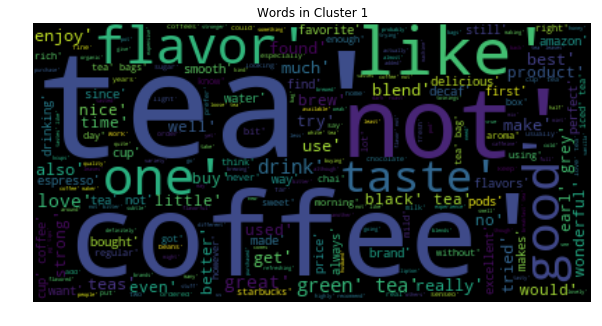

In [62]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(C1)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(C1))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 1")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:-

This word cloud has information about both tea and coffee and how they taste. 

### 8.7 Word Cloud for Cluster 2 

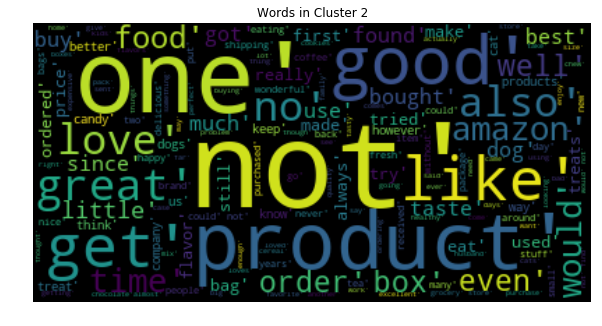

In [63]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(C2)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(C2))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 2")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:-

Word cloud has information about product, food and taste of the food. It also has information about orders and shopping.

### 8.8  Word Cloud for Cluster 3

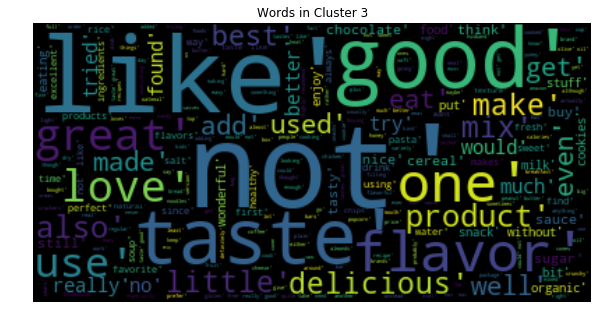

In [64]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(C3)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(C3))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 3")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:- 

This word cloud also has same information as the above one, it also says about food, product and taste.

## 9. TFIDF-W2V

In [65]:
model = TfidfVectorizer()
tfidfw2v_data = model.fit_transform(X)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))


In [66]:
print(tfidfw2v_data.get_shape())

(40000, 62436)


In [67]:
# TF-IDF weighted Word2Vec 

tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_words = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words:
            try:
                vec = w2v_model.wv[word]
            # tf_idf = tfidf_train_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_words.append(sent_vec)
    row += 1

## 9.1 Applying K-means clustering on TFIDF-W2V

### 9.2 Finding best K value by elbow method

In [68]:
# inertia = sum of intra-cluster distances across all cluster and it should be very low
from sklearn.cluster import KMeans

sum_of_intracluster_dist = []
K = [2,3,4,5,6,7,8,9,10]

for i in K:
    kmeans = KMeans(n_clusters = i, n_jobs = -1)
    kmeans.fit(tfidf_words)
    sum_of_intracluster_dist.append(kmeans.inertia_)
    

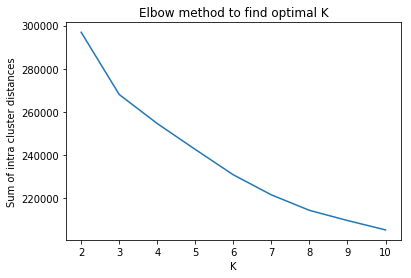

In [69]:
# Plotting between K and sum_of_intracluster_distances which is inertia
plt.plot(K, sum_of_intracluster_dist)
plt.xlabel('K')
plt.ylabel('Sum of intra cluster distances')
plt.title('Elbow method to find optimal K')
plt.show()

### 9.3 Retrain the model on optimal  K

In [70]:
# From the above plot, optimal k = 3
optimal_k = KMeans(n_clusters = 3, n_jobs = -1)
km = optimal_k.fit(tfidf_words)

In [71]:
km.labels_.shape[0]

40000

### 9.4 Finding number of words for each cluster

In [73]:
words_data = list_of_words
C1 = []
C2 = []
C3 = []

for i in range(km.labels_.shape[0]):
    if km.labels_[i] == 0:
        C1.append(words_data[i])
    elif km.labels_[i] == 1:
        C2.append(words_data[i])
    else:
        C3.append(words_data[i])
                
print("Number of words in Cluster 1 : ",len(C1))
print("Number of words in Cluster 2 : ",len(C2))
print("Number of words in Cluster 3 : ",len(C3))


Number of words in Cluster 1 :  16692
Number of words in Cluster 2 :  17805
Number of words in Cluster 3 :  5503


### 9.5 Word Cloud for Cluster 1

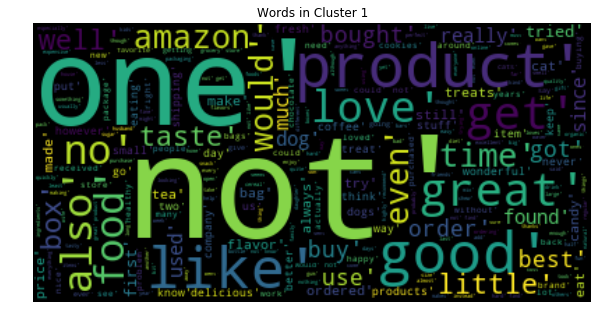

In [78]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(C1)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(C1))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 1")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:-

This word cloud has information about product, whether it is good or not. It also says about food, it's taste and buying information.

### 9.6  Word Cloud for Cluster 2

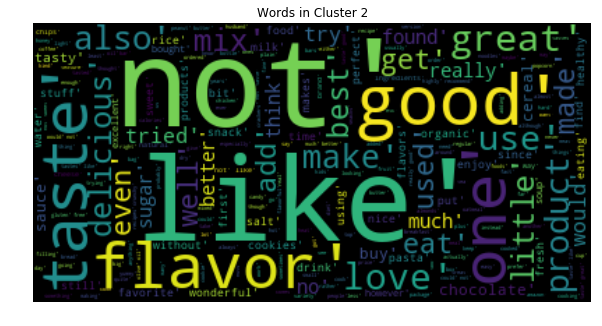

In [79]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(C2)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(C2))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 2")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:-

This word cloud also has same information as the above word cloud. 

### 9.7 Word Cloud for Cluster 3

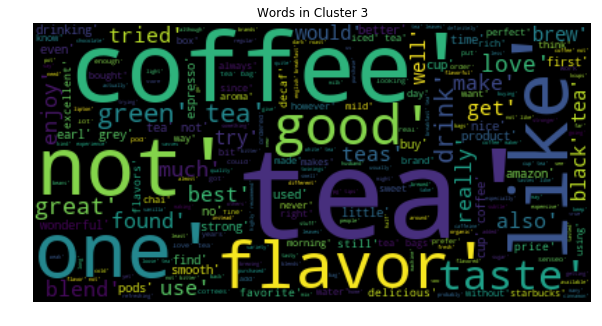

In [80]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(C3)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(C3))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 3")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:-

Word cloud represents category of tea and coffee, it's flavors and taste. It also has information of different types of tea and how they taste.

## 10. Models Summarization

In [2]:
from pandas import DataFrame
K_Means = {'Vectorizer':['BoW', 'TFIDF', 'AVG-W2V', 'TFIDF-W2V'], 'Model':['K-Means','K-Means','K-Means','K-Means'], 
                       'Optimal K value':['3','3','3','3']}

In [3]:
Final_conclusions = DataFrame(K_Means)
Final_conclusions

,Vectorizer,Model,Optimal K value
0,BoW,K-Means,3
1,TFIDF,K-Means,3
2,AVG-W2V,K-Means,3
3,TFIDF-W2V,K-Means,3


## 11. Conclusions:-

1. From the above observations we can see that all featurizations have same k = 3 value, which is number of clusters.
2. I applied K-means clustering algorithm on all 4 featurizations.